In [62]:
import zipfile
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import seaborn as sns
import numpy as np
zf = ZipFile('../house-prices-advanced-regression-techniques.zip','r')
tr = zf.read('train.csv')
te = zf.read('test.csv')
df_train = pd.read_csv(BytesIO(tr))
df_test = pd.read_csv(BytesIO(te))

house-prices-advanced-regression-techniquesのデータを用いて、前処理〜モデル作成を行う。  


- 前処理の手法：  
   数値データとラベルデータにわけ、それぞれ欠損処理と次元削減を行い、最後に横結合したものの相関を見て、次元削減を行ってみる。   
   数値データとラベルデータで分けたのは、ラベルデータをエンコーディングした時に、多重共線性が大きくなると予測できるので、個別に処理をしたいから。  


     1. 数値データ     
        - 数値データの欠損処理にBayesianRidge  
        - (本当は特徴量選択も入れて、スリムにする方がいいかも　また分散0の特徴量は意味ないから削る)
        - PCAで次元削減
    

     2. ラベルデータ
        - 欠損値の多い特徴量は削除、少ないものは最頻値で補完
        - エンコーディングにはOne-Hotエンコーディングを活用
    


- モデリングについて:
   - 今回は、L2正則化のリッジ回帰を用いて過学習を防ぎながらモデルを作っていく。
   
   
   


- グリッドサーチを用いながら、ハイパーパラメータを最良のものに設定する

In [63]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [64]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [66]:
print(df_train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [67]:
##IDは邪魔
df_train = df_train.drop(columns='Id')

In [68]:
##目的変数の状態を確認
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

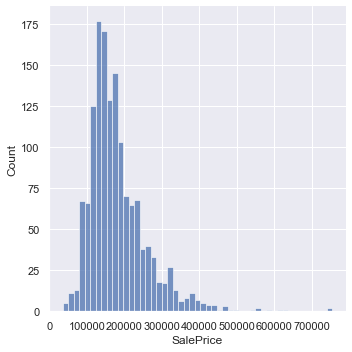

In [69]:
##目的変数の分布を確認
##左に裾野が長いグラフ←正の歪度がある
sns.displot(df_train['SalePrice'])

In [70]:
df_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [71]:
#歪度
#尖度　の計算
df_train['SalePrice'].skew()

1.8828757597682129

In [72]:
df_train['SalePrice'].kurt()

6.536281860064529

目的変数との関係を理解する ヒートマップで相関を確認

<AxesSubplot:>

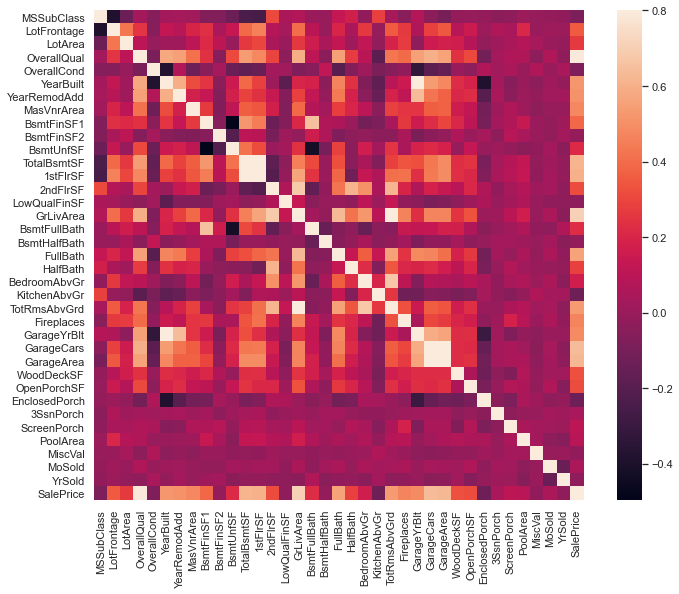

In [73]:
corrmat = df_train.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=.8,square=True)

目的変数に相関が高いもの→モデルに入れたら強そう  
説明変数同士で相関が高いもの→次元削減できそう

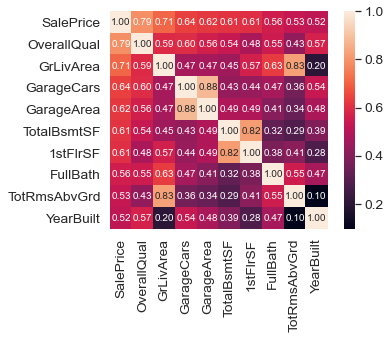

In [74]:
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index ##SalePriceに対する相関係数の順に取得できる
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)
plt.show()

In [75]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

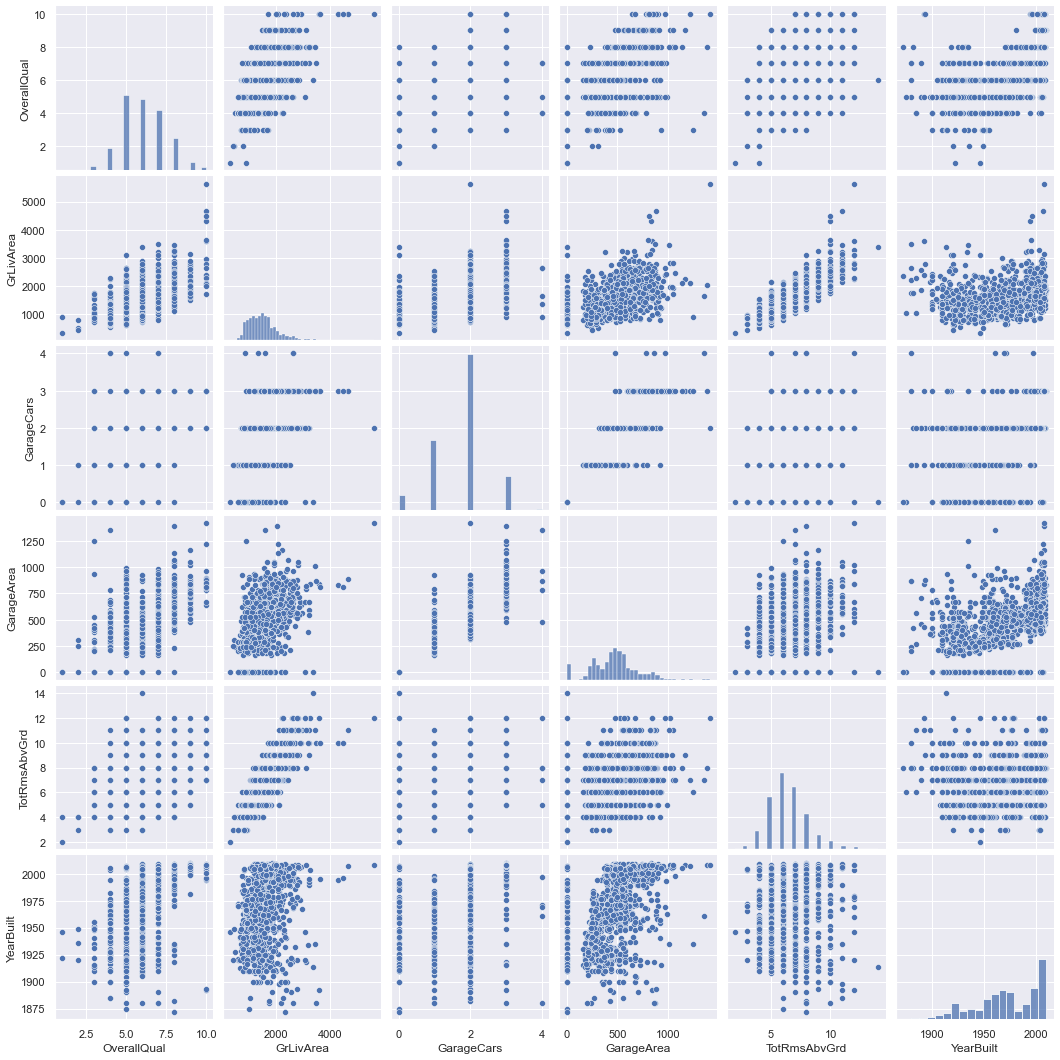

In [76]:
#この変数たちはいれたら良さそう
sns.set()
cols = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotRmsAbvGrd','YearBuilt']
sns.pairplot(df_train[cols],size=2.5)
plt.show()

ここまで質的・量的かかわらずにSalsepriceに対する相関を見た  
ここからは、質的と量的に分けて次元削減を試みる

## STEP_1 まずは数値データとラベルデータでデータを分け、数値データのnullを埋めていく

In [77]:
df_train_int = df_train.select_dtypes(include='number')
df_train_ob = df_train.select_dtypes(include='object')
X_train_int = df_train_int.drop('SalePrice',axis=1)
y_train_ = df_train_int['SalePrice']
X_train_ob = df_train_ob

### 数値データについて

In [78]:
#分散が0の値（情報を持っていない）を削除
X_train_int = X_train_int.iloc[:, [i for i, x in enumerate(X_train_int.var()) if x != 0]]

In [79]:
##欠損値の確認
X_train_int.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

欠損値を補完または削除するとき、欠損値が多ければ列をそのまま削除し、少なければ補完してしまう方がいいかも  
情報量が少ないから削除できるか、元の情報に大きく影響を与えないから削除できるか  
情報量は分散を意識する

In [80]:
X_train_int['LotFrontage']

0       65.0
1       80.0
2       68.0
3       60.0
4       84.0
        ... 
1455    62.0
1456    85.0
1457    66.0
1458    68.0
1459    75.0
Name: LotFrontage, Length: 1460, dtype: float64

In [81]:
X_train_int['GarageYrBlt']

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
         ...  
1455    1999.0
1456    1978.0
1457    1941.0
1458    1950.0
1459    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [82]:
X_train_int['MasVnrArea']

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1460, dtype: float64

BayesianRidge(ベイズリッジ回帰→特徴量データを細かく区切って、平均と分散で曲線を作る推定)で全て補完する  
https://www.haya-programming.com/entry/2019/11/05/225424

In [83]:
##データの標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_int_std =sc.fit_transform(X_train_int)

In [84]:
#欠損値補完
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_train_int_std = IterativeImputer().fit_transform(X_train_int_std)

In [85]:
X_train_int_std

array([[ 0.07337496, -0.20803433, -0.20714171, ..., -0.08768781,
        -1.5991111 ,  0.13877749],
       [-0.87256276,  0.40989452, -0.09188637, ..., -0.08768781,
        -0.48911005, -0.61443862],
       [ 0.07337496, -0.08444856,  0.07347998, ..., -0.08768781,
         0.99089135,  0.13877749],
       ...,
       [ 0.30985939, -0.16683907, -0.14781027, ...,  4.95311151,
        -0.48911005,  1.64520971],
       [-0.87256276, -0.08444856, -0.08016039, ..., -0.08768781,
        -0.8591104 ,  1.64520971],
       [-0.87256276,  0.20391824, -0.05811155, ..., -0.08768781,
        -0.1191097 ,  0.13877749]])

In [86]:
X_train_int_std = pd.DataFrame(X_train_int_std)

In [87]:
#データが補完できている
X_train_int_std.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
dtype: int64

In [88]:
X_train_int_std.columns = X_train_int.columns

In [89]:
##できた！
X_train_int_std

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.331620,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.572835,-0.973018,-0.288653,...,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439
1456,-0.872563,0.615871,0.266407,-0.071836,0.381743,0.222975,0.151865,0.084610,0.759659,0.722112,...,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210
1457,0.309859,-0.166839,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.572835,-0.369871,-0.288653,...,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210
1458,-0.872563,-0.084449,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.572835,-0.865548,6.092188,...,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210


数値データのtrainをPCAで次元削減してみる

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=31)
X_train_int_std_pca = pca.fit_transform(X_train_int_std)
##テストデータは後ほどまとめて

In [91]:
##分散説明率の累積(説明分散/全分散) 31の主成分で99%説明できる→５個削れた
np.cumsum(pca.explained_variance_ratio_)

array([0.20166858, 0.29138491, 0.36463593, 0.42081884, 0.4618157 ,
       0.49500781, 0.52706995, 0.55830675, 0.58906448, 0.61932602,
       0.64826383, 0.67649641, 0.7046496 , 0.73138039, 0.75662776,
       0.78169414, 0.80516872, 0.82773716, 0.84966035, 0.86999485,
       0.88867933, 0.90578744, 0.92195162, 0.93548242, 0.94637584,
       0.95578586, 0.96454301, 0.97235408, 0.97947736, 0.98512012,
       0.99051747])

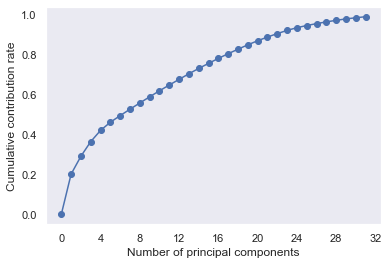

In [92]:
##累積寄与りつのグラフ
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [93]:
##モデル作成にデータが使えるように、固有値ベクトルを保存しておく
X_train_int_std_pca = pd.DataFrame(X_train_int_std_pca)

In [94]:
##36→31になったが、何にまとまったかは不明　 完成！
X_train_int_std_pca

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.494903,0.279727,-1.735941,-1.914767,0.516820,1.140687,-0.651006,-0.371277,-0.657612,0.168585,...,0.353157,0.113686,0.050974,0.206820,-0.367417,0.580110,-0.370638,-0.060855,0.163409,-0.263325
1,-0.013788,-1.013407,1.252551,-0.052733,-1.777414,0.094071,3.290422,0.404332,0.917878,-0.112806,...,-0.471576,-0.478227,-0.300205,0.363689,0.266772,-0.814757,-1.008658,0.605813,0.046577,0.022190
2,1.679198,0.171532,-1.512823,-1.350817,-0.117983,-0.330061,-0.116009,-0.357667,-0.657853,0.203048,...,-0.453708,0.183187,0.009358,-0.358047,-0.290744,0.448359,-0.456440,0.646757,0.028733,0.185920
3,-0.327969,1.008964,0.605181,-0.212806,0.462998,0.183258,-1.653486,0.762356,-2.053732,1.317686,...,0.466997,-0.049862,0.386717,-1.213546,-0.222007,0.812161,-0.203976,-0.799720,0.827159,0.078501
4,4.401480,1.120911,-0.618799,-1.401731,-0.074228,-0.588012,0.684949,-0.511345,-0.881584,0.148057,...,0.153453,-0.088353,0.426849,-0.736780,-0.037084,0.503918,-0.147468,-0.143587,-0.145533,0.081196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.858382,1.234146,-2.087847,0.549048,-0.531803,-0.564983,-0.093999,-0.181164,-0.562760,-0.418541,...,-0.859699,0.437646,-0.142814,-0.082651,-0.403551,-0.175836,0.157846,0.610742,0.168809,0.079695
1456,2.326751,-1.569277,2.368025,0.061426,0.423438,2.273514,-0.223519,-0.131545,1.009217,-0.604610,...,-0.927747,-0.780736,-0.392430,-0.147741,-0.099491,-0.091124,0.344352,0.622920,0.086845,-0.517513
1457,0.428956,3.418342,1.408452,-0.119300,-1.493863,2.344260,0.387028,1.195776,3.476824,1.766565,...,-1.637445,-1.413510,0.968636,-0.237224,-0.002183,0.350384,0.260300,0.022614,0.261828,0.650200
1458,-2.802930,-1.943174,1.983331,-1.083735,-0.590489,2.748533,-0.196338,1.036746,0.991819,-4.056480,...,0.880335,0.081775,-0.958602,0.413827,-0.015643,0.704789,0.170824,-0.145238,-0.342414,0.420428


### ラベルデータについて

In [95]:
X_train_ob

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [96]:
##nullの数...
X_train_ob.isnull().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [97]:
##どれだけnullがあるか割合を見てみる
total = X_train_ob.isnull().sum().sort_values(ascending=False)
percent = (X_train_ob.isnull().sum()/X_train_ob.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
GarageType,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
BsmtFinType2,38,0.026027


In [98]:
##FireplaceQuより上の変数を削除する→家を購入する時に選ばないし、変に補完したらモデルに大きく影響しそう。。。
drop = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
X_train_ob = X_train_ob.drop(drop,axis=1)

In [99]:
##特徴量が43→38に減っている
X_train_ob

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


質的変数なので、エンコーディングをする必要があるが、まずはnull値を埋めないといけないので、  
最頻値で埋める

In [100]:
from sklearn.impute import SimpleImputer
X_train_ob_mf = SimpleImputer(strategy='most_frequent').fit_transform(X_train_ob)

In [101]:
X_train_ob_mf = pd.DataFrame(X_train_ob_mf)
X_train_ob_mf.columns = X_train_ob.columns

In [102]:
##Nullを最頻値で埋めた
X_train_ob_mf

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


今回は、One-Hotで対処してみる

In [103]:
X_train_ob_mf_one = pd.get_dummies(X_train_ob_mf,sparse=False)

In [104]:
X_train_ob_mf_one

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [105]:
X_train_ = pd.concat([X_train_int_std_pca,X_train_ob_mf_one],axis=1)

In [106]:
X_train_

,0,1,2,3,4,5,6,7,8,9,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.494903,0.279727,-1.735941,-1.914767,0.516820,1.140687,-0.651006,-0.371277,-0.657612,0.168585,...,0,0,0,1,0,0,0,0,1,0
1,-0.013788,-1.013407,1.252551,-0.052733,-1.777414,0.094071,3.290422,0.404332,0.917878,-0.112806,...,0,0,0,1,0,0,0,0,1,0
2,1.679198,0.171532,-1.512823,-1.350817,-0.117983,-0.330061,-0.116009,-0.357667,-0.657853,0.203048,...,0,0,0,1,0,0,0,0,1,0
3,-0.327969,1.008964,0.605181,-0.212806,0.462998,0.183258,-1.653486,0.762356,-2.053732,1.317686,...,0,0,0,1,1,0,0,0,0,0
4,4.401480,1.120911,-0.618799,-1.401731,-0.074228,-0.588012,0.684949,-0.511345,-0.881584,0.148057,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.858382,1.234146,-2.087847,0.549048,-0.531803,-0.564983,-0.093999,-0.181164,-0.562760,-0.418541,...,0,0,0,1,0,0,0,0,1,0
1456,2.326751,-1.569277,2.368025,0.061426,0.423438,2.273514,-0.223519,-0.131545,1.009217,-0.604610,...,0,0,0,1,0,0,0,0,1,0
1457,0.428956,3.418342,1.408452,-0.119300,-1.493863,2.344260,0.387028,1.195776,3.476824,1.766565,...,0,0,0,1,0,0,0,0,1,0
1458,-2.802930,-1.943174,1.983331,-1.083735,-0.590489,2.748533,-0.196338,1.036746,0.991819,-4.056480,...,0,0,0,1,0,0,0,0,1,0


線形回帰で今回はモデルを作る

In [109]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_train_,y_train_,test_size=0.4,random_state=0)
ridge = Ridge().fit(X_train,y_train)

In [110]:
#過学習気味　おそらく、質的変数のOne-Hotが多重共線性を起こしているかも alphaのパラメータで調整
print("Training set score:{:.2f}".format(ridge.score(X_train,y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test,y_test)))

Training set score:0.94
Test set score: 0.75


In [111]:
#だいぶいい結果になってきた！　→いや、本当？？
ridge10 = Ridge(alpha=10).fit(X_train,y_train)
print("Training set score:{:.2f}".format(ridge10.score(X_train,y_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test,y_test)))

Training set score:0.92
Test set score: 0.80


In [112]:
np.arange(30,40.1,0.1)

array([30. , 30.1, 30.2, 30.3, 30.4, 30.5, 30.6, 30.7, 30.8, 30.9, 31. ,
       31.1, 31.2, 31.3, 31.4, 31.5, 31.6, 31.7, 31.8, 31.9, 32. , 32.1,
       32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8, 32.9, 33. , 33.1, 33.2,
       33.3, 33.4, 33.5, 33.6, 33.7, 33.8, 33.9, 34. , 34.1, 34.2, 34.3,
       34.4, 34.5, 34.6, 34.7, 34.8, 34.9, 35. , 35.1, 35.2, 35.3, 35.4,
       35.5, 35.6, 35.7, 35.8, 35.9, 36. , 36.1, 36.2, 36.3, 36.4, 36.5,
       36.6, 36.7, 36.8, 36.9, 37. , 37.1, 37.2, 37.3, 37.4, 37.5, 37.6,
       37.7, 37.8, 37.9, 38. , 38.1, 38.2, 38.3, 38.4, 38.5, 38.6, 38.7,
       38.8, 38.9, 39. , 39.1, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7, 39.8,
       39.9, 40. , 40.1])

まだいい感じかわからん(たまたま予測が簡単なデータセットにあたったかも)、ここで交差検証を行う

In [113]:
#5分割検証
from sklearn.model_selection import cross_val_score
rige_ = Ridge()
scores = cross_val_score(rige_,X_train_,y_train_)
print("Cross-validation scores:{}".format(scores))

Cross-validation scores:[0.90030323 0.8286848  0.8687599  0.87989403 0.6955463 ]


In [114]:
#パラメータcvで10分割した時の精度を確認
scores = cross_val_score(rige_,X_train_,y_train_,cv=10)
print("Cross-validation scores:{}".format(scores))

Cross-validation scores:[0.90305278 0.91013766 0.89674222 0.78314834 0.89003171 0.86026734
 0.87821768 0.87862433 0.56255688 0.88783736]


交差検証の精度を平均値でまとめる

In [115]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.85


モデルの予測精度は、85%で正しいことがお分かりいただけただろうか？  
いや、実は分割した時に予測しにくいデータが固まったかもしれない。。。  
特に、0.56255688　という数値は怪しい。本当の実力を見てみよう。  
層化k分割交差検証(テストデータをバラバラにとる)

In [116]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10,shuffle=True,random_state=0) #10分割、データをシャッフルして分割、分割した値は固定(読み込み直しても同じ結果)
scores_2 = cross_val_score(rige_,X_train_,y_train_,cv=kfold)
print("Cross-valudation scores:\n{}".format(
    cross_val_score(rige_,X_train_,y_train_,cv=kfold)
))

Cross-valudation scores:
[0.80768066 0.43429124 0.90240001 0.85939857 0.75330347 0.9362111
 0.90725184 0.89344784 0.88886987 0.89156342]


In [117]:
print("Average cross-validation score: {:.2f}".format(scores_2.mean()))

Average cross-validation score: 0.83


さがっとるやないか！  
現実を見たくない　  
別の交差検証をしてみよう  
シャッフル分割交差検証  

In [118]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5,train_size=.5,n_splits=10)
scores_3 = cross_val_score(rige_,X_train_,y_train_,cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores_3))

Cross-validation scores:
[0.85790978 0.8438521  0.75390658 0.77353768 0.77602438 0.85194536
 0.85599426 0.81618602 0.84364597 0.78611812]


In [119]:
print("Average cross-validation score: {:.2f}".format(scores_3.mean()))

Average cross-validation score: 0.82


しっかり前処理とモデル選択を頑張る方が良さそう  
81~85%間で予測ができそう 
だが、、、

alpha をいい感じにしたい→グリッドサーチ(試したいパラメータ全部試す)を用いて、パラメータを探す

In [128]:
list_p = list(np.arange(9,21,0.1)) ##alphaを20~30を0.1刻みで見た時にどうなるか？
param_grid = {'alpha':list_p} #パラメータを設定
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
grid_search = GridSearchCV(Ridge(),param_grid=param_grid,cv=10)
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_train_,y_train_,random_state=0)
grid_search.fit(X_train_2,y_train_2)
print("Test set score:{:.2f}".format(grid_search.score(X_test_2,y_test_2)))

Test set score:0.75


さがった。。。。  
グリッドサーチのスコアをテストデータに入れて確認してみる
その前に、ここまでやった流れをまとめる

- 前処理の手法：  
   数値データとラベルデータにわけ、それぞれ欠損処理と次元削減を行い、最後に横結合したものの相関を見て、次元削減を行ってみる。   
   数値データとラベルデータで分けたのは、ラベルデータをエンコーディングした時に、多重共線性が大きくなると予測できるので、個別に処理をしたいから。  


     1. 数値データ     
        - 分散0の特徴量は意味ないから削る 
        - 数値データの欠損処理にBayesianRidge  
        - (本当は特徴量選択も入れて、スリムにする方がいいかも)
        - PCAで次元削減
    

     2. ラベルデータ
        - 欠損値の多い特徴量は削除、少ないものは最頻値で補完
        - エンコーディングにはOne-Hotエンコーディングを活用
    


- モデリングについて:
   - 今回は、L2正則化のリッジ回帰を用いて過学習を防ぎながらモデルを作っていく。
   
   
   


- グリッドサーチを用いながら、ハイパーパラメータを最良のものに設定する

2回目からは処理を関数にまとめる(本来はtrainの時にまとめておくほうがいい)

In [169]:
# df_train_int = df_train.select_dtypes(include='number')
# df_train_ob = df_train.select_dtypes(include='object')
# X_train_int = df_train_int.drop('SalePrice',axis=1)
# y_train_ = df_train_int['SalePrice']
# X_train_ob = df_train_ob

def types(df):
    df_ob = pd.DataFrame()
    df_int = pd.DataFrame()
    for col_name,item in df.iteritems():
        if item.dtypes == 'object':
            df_ob[col_name] = item
        else:
            df_int[col_name] = item
    df_int  = df_int .iloc[:, [i for i, x in enumerate(df_int .var()) if x != 0]]
    return df_ob,df_int

In [170]:
X_test_ob,X_test_int = types(df_test)

In [171]:
X_test_int

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,286.0,0,24,0,0,0,0,0,4,2006
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,576.0,474,0,0,0,0,0,0,9,2006
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [172]:
X_test_ob

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,WD,Normal
1455,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,CarPort,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,Shed,WD,Normal


In [155]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
#from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer
# from sklearn.linear_model import Ridge
#from sklearn.model_selection import GridSearchCV

# sc = StandardScaler()
# X_train_int_std =sc.fit_transform(X_train_int)
# X_train_int_std = IterativeImputer().fit_transform(X_train_int_std)
# X_train_int_std = pd.DataFrame(X_train_int_std)
#pca = PCA(n_components=31)
#X_train_int_std_pca = pca.fit_transform(X_train_int_std)
#X_train_ob_mf = SimpleImputer(strategy='most_frequent').fit_transform(X_train_ob)
# X_train,X_test,y_train,y_test = train_test_split(X_train_,y_train_,test_size=0.4,random_state=0)
# ridge = Ridge().fit(X_train,y_train)
# list_p = list(np.arange(9,21,0.1)) 
# param_grid = {'alpha':list_p}
# grid_search = GridSearchCV(Ridge(),param_grid=param_grid,cv=10)
# X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X_train_,y_train_,random_state=0)
# grid_search.fit(X_train_2,y_train_2)
# print("Test set score:{:.2f}".format(grid_search.score(X_test_2,y_test_2)))

In [162]:
def int_change(df_int):
    sc = StandardScaler()
    df_int_std =sc.fit_transform(df_int)
    df_int_std = pd.DataFrame(df_int_std)
    df_int_std = IterativeImputer().fit_transform(df_int_std)
    pca = PCA(n_components=31)
    df_int_std_pca = pd.DataFrame(pca.fit_transform( df_int_std))
    return df_int_std_pca

def ob_change(df_ob):
    df_ob_mf = SimpleImputer(strategy='most_frequent').fit_transform(df_ob)
    df_ob_mf = pd.DataFrame(df_ob_mf)
    df_ob_mf.columns = df_ob.columns
    df_ob_mf_one = pd.get_dummies(df_ob_mf,sparse=False)
    return df_ob_mf_one

In [163]:
X_test_int = int_change(X_test_int)
X_test_ob = ob_change(X_test_ob)

In [161]:
X_test_int

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-0.950783,-0.809650,-1.294060,0.408902,-0.052757,0.031291,0.821995,-1.326302,0.244167,0.444115,...,-0.778532,0.562760,0.274886,0.790495,-0.503353,1.267750,0.352299,0.703855,-0.702337,1.497559
1,3.120892,0.092552,-1.229980,-1.938002,1.495093,0.206259,1.936794,1.323239,-0.349842,7.000554,...,-0.130655,1.877355,1.459894,-1.551056,-3.977835,3.998635,-1.575939,3.669211,4.899495,1.177037
2,-0.193412,0.364154,-1.932708,0.333655,-0.734018,-0.192532,0.118277,-0.808454,-0.596415,1.579557,...,-0.098823,0.078615,0.807273,-0.455722,-1.334577,-1.280895,-0.283798,-0.430368,-1.146352,0.353602
3,-0.092670,0.481627,-2.106414,-0.171199,-0.267283,-0.201464,0.109138,-0.638164,0.624059,0.934719,...,0.254660,-0.166696,0.119559,-0.795999,-1.021337,-0.629106,0.561741,0.185647,-1.434845,0.800997
4,-0.089279,0.050078,0.175705,-0.330775,-0.572237,0.684652,0.874416,-1.712198,0.125032,0.093846,...,-2.005936,2.639831,-0.969225,1.549054,0.921306,-0.297726,0.772735,-0.699693,-0.305215,0.097218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.842025,-1.693121,-0.403428,-0.610535,-0.694273,1.061294,-0.661689,1.227104,-0.330659,-0.736115,...,-0.869599,-0.290321,0.189743,-1.803133,0.243174,-2.425262,0.201275,0.684751,-0.768194,-0.485460
1455,0.681364,-1.244836,-0.350392,-0.625272,0.536968,0.877287,-0.047775,0.262764,-0.400365,0.047367,...,-1.206056,-1.134850,0.577304,-0.300662,0.342717,-2.716439,-0.377531,-0.389172,-0.050426,-0.033284
1456,0.058998,0.405174,-1.627409,0.791130,1.084382,0.786631,2.064338,1.631692,-0.411333,-0.274950,...,-0.238487,-2.185837,-0.481645,-1.255724,-2.656364,1.830080,-1.512222,-0.764803,-2.422712,2.123763
1457,-1.708336,-0.983569,-0.311751,-0.345655,0.858723,1.513682,-0.611816,0.347158,-1.322620,-0.100852,...,1.540221,-0.363458,-1.409013,-1.205758,0.389858,-0.490903,-1.270957,-0.083370,0.682192,-0.566193


In [164]:
X_test_ob

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,1,1,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1455,0,0,0,0,1,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1456,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1457,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [165]:
X_test_ = pd.concat([X_test_int,X_test_ob],axis=1)

In [166]:
X_test_

,0,1,2,3,4,5,6,7,8,9,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.791700,-0.461454,-0.014956,0.193699,0.482408,-0.365085,0.378833,-0.617810,0.921399,0.658180,...,0,0,0,1,0,0,0,0,1,0
1,-1.572874,1.690264,4.029923,3.927513,1.245605,3.978127,-0.575882,-0.204270,5.568514,-3.028734,...,0,0,0,1,0,0,0,0,1,0
2,1.567331,-0.453215,-0.126103,-1.185905,-0.703970,-0.676730,0.654326,-0.156883,-0.036035,0.734458,...,0,0,0,1,0,0,0,0,1,0
3,1.444669,0.357194,0.485396,-0.390823,-0.242017,-0.225142,1.246242,-0.639628,0.245515,0.529816,...,0,0,0,1,0,0,0,0,1,0
4,-0.263033,-1.247453,-0.471957,-0.165343,0.489381,-0.727707,-1.425715,-0.240783,-0.717199,-0.026180,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.280674,0.413265,1.340395,-0.534527,-0.907608,-1.660243,-0.071392,0.298641,-1.467421,0.622794,...,0,0,0,1,0,0,0,0,1,0
1455,0.018650,-0.528277,-0.019649,-0.581334,-1.469356,-1.711820,-1.287683,0.537215,-0.829530,0.053645,...,0,0,0,1,1,0,0,0,0,0
1456,1.924352,0.472303,1.128753,0.412321,0.535268,1.215170,-0.305166,0.823372,0.223458,2.611816,...,0,0,0,1,1,0,0,0,0,0
1457,1.672375,1.052694,-0.015639,1.690429,1.337263,-1.312997,-1.838595,-0.645195,-0.849054,1.158147,...,0,0,0,1,0,0,0,0,1,0


In [243]:
#答えのわからないテストデータを予測してみる(Ridgeはpredictで予測値を返す)
#カラム名に予測した列をつける
#提出にはidも必要となる
submission = pd.DataFrame(grid_search.predict(X_test_),columns=['SalePrice'])
ids = X_test_int['Id']
submission = pd.concat([ids,submission],axis=1)

In [247]:
submission.columns

Index(['Id', 'SalePrice'], dtype='object')

In [248]:
submission.to_csv('submission.csv', index=False)

総括：  
前処理に関して、必要なデータのみを抽出することや質的変数をより加工すること  
非線形モデルの採用、アンサンブル学習をするなどまだまだ改善の余地がありそうです